# Group information

Names: Andreas Cisi Ramos e João Pedro de Moraes Novaes


RAs: 246932 e 174494

## Objective:

To explore **deep learning** techniques, focused on **Convolutional Neural Networks**. In this task you'll be architecturing different CNNs to solve an image classification problem.

This **MUST** be developed using the pytorch and Sklearn libraries (PyTorch Lightning is **not** allowed).

*Tip: Use the Pillow (PIL) library to work with images with pytorch. Also, you can use [tqdm](https://github.com/tqdm/tqdm) library to see the progress of the training process.*

## Dataset

The dataset you should use is an adaptation of the "CIFAR10" dataset. The CIFAR10 dataset is a dataset of 32x32 images of 10 different classes, and is extensivelly used for classification of images using CNN.

In this work, You will only use CIFAR10 data of 3 classes: airplane, bird and cat. You also will only use a limited amount of the data of each class (the original dataset has 6000 images per class). For each class, the amount of images is 400 for training, 200 for validation and 300 for test. This is defined so that the training steps are faster, but it makes the problem harder, as we are working with few data points.


The dataset will be available in the [same folder](https://drive.google.com/drive/folders/14uiy_7xMq5LOqODBzbIJLD4Vq0E9XD5v) as the other tasks, in the "cifar_mod" folder. You can copy the dataset folder or download it locally.

Here are some examples of each class from the dataset:

**airplane**

**bird**


**cat**



As in every machine learning task, we need to understand and analyze the data. From the way that the dataset was collected (data collection protocol, equipment used, people involved), to its final result (resulting files) and objective. When dealing with images, we usually want to track possible biases that different classes may have when collected. This dataset contains images of the target objects in a centered position in the foreground, having few biases related to the common background of some classes (for example: airplanes in the blue sky).

As in the other tasks we already covered the data analysis part, we will focus on the technical machine learning parts for this one. Just remember that images are another type of data and we also could (and **should**) analyze the information before applying machine learning techniques blindly.

## Load the dataset (2 Points)

When working with Pytorch, we need to create a "Dataset" class that usually will handle the data loading, as well as the data transformations, and will allow us to retrieve the data with the respective label.

Data transformations are an important part of Pytorch datasets, as we already studied in the lectures that data augmentation can be powerful in training deep neural networks. But some of those transformations are just to define the entry of the model as Pytorch tensors or normalizing data, which can be impactful as well.

Create a Pytorch Dataset and Dataloader with and without data augmentation for training data (to compare later). The `Dataset` class has 3 required methods: `__init__`, `__len__`, and `__getitem__`. In the code below we have some basic idea of an ImageDataset.

You can choose how to implement the image loading in the class:
- Inside the `__getitem__` method (low memory usage for each dataset instance, slower for training)
- Inside the `__init__` method (saves all images on memory, but training is faster)

Either implementation is ok, if the machine you're using supports the loading of all images this is probably better for performance.

For a deeper look at Pytorch datasets and dataloaders, look [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

The images are already divided by folder for train, validation and test, and you should follow this order. The targets of each image are described in the filename in the following pattern: `[image_number]_[class].jpg`.

To create the data augmentation you can follow the `preparation` example below, and add different Pytorch transformations. A list of available transformations (as well as examples) can be found in the [official documentation (here)](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended).

In [45]:
import torch
from torch import nn as nn
import torchvision.transforms.v2 as transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2

# IMPORTS
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [69]:
input_width =  32 
input_height = 32
nchannels = 3

# train transformations - Data Augmentation : transformaçoes como flip / rotação / brilho 
augmentation = transforms.Compose([
    transforms.Resize((input_width, input_height), interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# test transformations - here we should only have the transformations needed for preparing the data for the model
preparation = transforms.Compose([
              # make all images the same size with a specific interpolation method
              transforms.Resize((input_width,input_height), interpolation=transforms.InterpolationMode.BILINEAR,
                                max_size=None, antialias=True),
              # transform the image to Tensor (this will change the configuration from Height x Width x Channels to Channels x Height x Width)
              transforms.ToTensor(),
              # this normalization is just an example, based on the ImageNet mean and standard deviation of images. You can test without it if you want!
              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          ])

class ImageDataset():
  def __init__(self, directoryRoot, transform=None):

    #self variables
    self.directoryRoot = directoryRoot
    self.transform = transform
    self.filenames = []
    self.indexToClassDictionary = {0:'airplane', 1:'bird', 2:'cat'}
    
    for root, _, files in os.walk(directoryRoot):
      for file in files:
          self.filenames.append(os.path.join(root, file))
    

  def __len__(self):
    return len(self.filenames) # Attention: change this line if your __init__ method uses another attribute to keep the images/filenames

  def __getitem__(self, idx):
    '''
    Return a tuple with the image (as a Tensor) and the respective target at position idx.
    '''
    imageName = self.filenames[idx]
    image = Image.open(imageName).convert('RGB') 
 
    # For debbuging
    #print(os.path.basename(imageName)) 

    # Retirando o index do nome do arquivo
    labelIndex = int( os.path.basename(imageName).split('_')[-1].split('.')[0] )
    label = self.indexToClassDictionary[ labelIndex ]  
    
    if self.transform:
        image = self.transform(image)
    
    return image, label


### Criando os Datasets e os Dataloaders

In [100]:
# Criando os Datasets
trainDataset = ImageDataset('cifar_mod/train', augmentation)
validationDataset = ImageDataset( 'cifar_mod/valid', preparation)
testDataset = ImageDataset('cifar_mod/test', preparation)

#Criando os DataLoaders
batch_size = 32

train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(validationDataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Testando o metodo __get_item__ e a visualização de imagem

Number of images: 1200
Images are 32x32x3
Class of the image:  bird


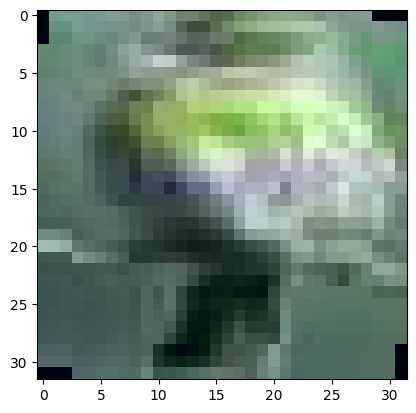

In [101]:
# Visualize images from the training set

datatensor = trainDataset
print("Number of images:", len(datatensor))
image, target = datatensor[100] # This will execute the '__getitem__' method
nchannels = image.shape[0]
height    = image.shape[1]
width     = image.shape[2]
image     = image.permute(1,2,0).numpy() # Converts the Tensor back to image shape
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target)
plt.show()

## Train a baseline model (1 Point)

Before going for the deep learning approach, you should test a baseline model in this problem. To do so, train a RandomForectClassifier, where the inputs are the flattened images (all pixes of 3 channels concatenated).

You should use the same train/validation/test division that you'll be using in the next section. You can use the Sklearn library for this task. Remember to test and plot a confusion matrix with the results.

In [122]:
#Imports
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Load Data

Para carregar os dados é necessário carregar as imagens e achatar cada uma delas para criar um vetor (1D). Isso se deve ao fato de cada imagem ser 32x32 pixels e ter 3 canais de cor . Com isso, é necessário converter para um vetor unidimensional de 3072 elementos (32 * 32 * 3).

In [123]:
def loadDataset(dataset):
    data = []
    labels = []
    
    for i in range(len(dataset)):
        image, label = dataset[i]
        # Achatamento
        image = image.view(-1).numpy()

        data.append(image)
        labels.append(label)
    
    return np.array(data), np.array(labels)

### Carregar dados de treinamento, validação e teste

In [124]:
X_train, y_train = loadDataset(trainDataset)
X_validation, y_validation = loadDataset(validationDataset)
X_test, y_test = loadDataset(testDataset)

#### Treinar o RandomForestClassifier

In [125]:

randomForest = RandomForestClassifier(n_estimators = 100, random_state = 42)
randomForest.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### Acurácia no conjunto de validação

In [126]:
y_validation_pred = randomForest.predict(X_validation)

validation_accuracy = np.mean(y_validation_pred == y_validation)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

Validation Accuracy: 66.50%


#### Acurácia no conjunto de teste

In [127]:
y_test_pred = randomForest.predict(X_test)

test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 64.78%


## Confusion Matrix

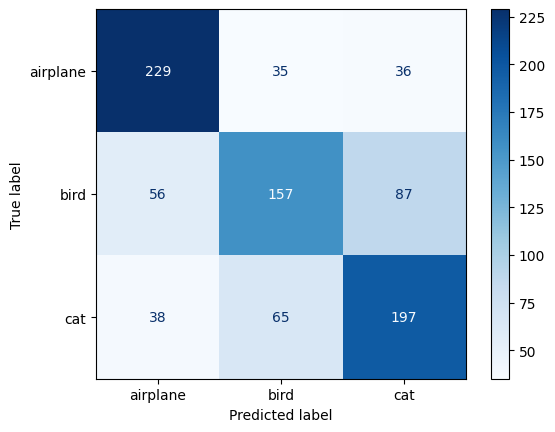

In [128]:
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=['airplane', 'bird', 'cat'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['airplane', 'bird', 'cat'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Build a CNN (6 Points)

In this section, you should construct and validate a CNN architecture for the given problem.

It's required that you test at least the following parts of a CNN:
- Number of convolutional layers and different output sizes
- Kernel size of filters
- Number of training epochs
- Learning rate of the network
- Batchsize used in dataloader
- Stride on convolutional or pooling layers
- Different architecture for the final dense layer (with or without hidden layers and their size)

Also, you must compare at least for one network if the data augmentation is helping the training process or not.

Lastly, you must change the `Criterion` function to return the balanced accuracy instead of the normal one.

--------

The process to build a CNN is an exploratory analysis and should be done carefully. As this is a costly process, you will not test all possibilities between each other, you should interpret the results at each step and understand what is happening or not happening.

As this is a costly process, you should use the normal division of train/validation/test, instead of cross validation. Also, at each network built and trained/validated, you should look at the results to understand if any overfitting or underfitting is happening. Save the values of each batch of train and validation to analyze how the model performed over the epochs.

### Exploding/vanishing gradients

As we already learned, the weights of a neural network are updated using the backpropagation algorithm. As our network grows in depth, there are two problems that can occur with the backpropagation algorithm, known as Exploding and Vanishing gradients.

As both names imply, both conditions relate to a gradient calculation that goes out of control for some reason.

The exploding gradient can happen when the current weights generate a very large loss, and all the network weights are updated by a huge amount. This can lead to a cycle where the network is not able to learn because every learning step impacts too much the network, making it very unstable.

On the other side, the vanishing gradient will happen when the gradients get too small, and the updates are not able to propagate to the initial layers.

There are a couple of ways to solve those issues. The first is to use an activation function that is "non-saturating". The sigmoid function is an example of a saturating function because its derivative tends to 0 on larger positive or negative values. The best activation functions to avoid this issue are the ReLU and its variations (LReLU, PReLU, ELU, etc). All those examples help to mitigate the vanishing gradient.

Another important step is to initialize the weights of the network properly. Initializing the weights randomly can also lead to vanishing/exploding gradients in some situations. The common strategy is to use a heuristic. We are not going to cover this manner in a deeper aspect, but the Xavier initialization is already implemented in the example below.

Finally, the best thing to avoid vanishing and exploding gradients in a deep CNN is to use the Batch Normalization technique. This technique is a new operation on the CNN, that normalizes its input and adds a parameter for scale and another for shifting. This enables the network to learn the optimal scale and mean of the layer. This normalization uses the data of the batch of images being executed on the model to find the mean and standard deviation. In pytorch, there is a function to use this technique in the `nn` module: `nn.BatchNorm2d()`. The BatchNorm operation can be used before or after the activation function.

For example:
- Conv -> BatchNorm -> Activation(ReLU) -> Pooling
Or
- Conv -> Activation(ReLU) -> BatchNorm -> Pooling).

In this task, you may face problems concerning the stability and convergence of the network because of the exploding or vanishing gradients, and it is recommended that you use the techniques cited to avoid this issue.

In [129]:
gpu = torch.cuda.is_available()

if not gpu:
  print("GPU not available!")

device = torch.device(0) if gpu else torch.device('cpu')

GPU not available!


**Saving models**

As the CNN training process can take some time, is interesting to save your models, to avoid re-training in the case of a crash or just to save your work for other time.

The next cell shows a simple code to save and load pytorch models. Remember to keep the class of the model in the same way, as the state_dict will not work if you change the architecture. Create new classes for different tests, with names that correctly describe what is being tested.

**Note**: If you're using google colab, just saving the model is not enough. You need to save it for a folder in your google Drive, or download the files after saving them.

In [135]:
# SIMPLIFICANDO EM UMA FUNÇÃO PARA PODER CHAMAR PARA DIFERENTES MÉTODOS

def load_model(model):
    
    #model = Model(input_shape, nclasses)
    state_dict  = torch.load("/savedModels")
    model.load_state_dict(state_dict)
    model = model.to(device)
    return

def save_model(model):
    torch.save(model.to('cpu').state_dict(), "/savedModels")
    return

**Example of train/validate code**

In the next cells, we show an example of how to develop the train/validation functions using pytorch. You don't need to use this code, but it is a place to start.

In [132]:

def train_batch(model, data, optimizer, criterion, device):
  '''
  Funtion that trains a batch of data in the 'device' (that should be a GPU)
  'data' is a batch of the dataloader.
  'optmizer' should be an instance of an pytorch optmizer. You don't need to test different optmizers, just go with SGD (torch.optim.SGD).
  'criterion' is a custom function to calculate the loss and accuracy of the predictions of the batch.
  'device' is the device that the model is loaded on.
  '''
  model.train()
  ims, targets = data
  ims = ims.to(device=device)
  targets = targets.to(device=device)
  preds = model(ims)
  loss, acc = criterion(model, preds, targets, device)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  return loss.item(), acc.item()

# This line avoid that the model weights change during validation
@torch.no_grad()
def validate_batch(model, data, criterion, device):
  '''
  Funtion that validates a batch of data in the 'device' (that should be a GPU).
  Same parameters as 'train_batch', but this time no optmizer is needed.
  '''
  model.eval()
  ims, targets = data
  ims = ims.to(device=device)
  targets = targets.to(device=device)
  preds = model(ims)
  loss, acc = criterion(model, preds, targets, device)

  return loss.item(), acc.item()

def Criterion(model, preds, targets, device):
  '''
  Function that calculates the loss and accuracy of a batch predicted by the model.
  '''
  ce            = nn.CrossEntropyLoss().to(device) # You don't need to change the loss function (but you can if it makes sense on your analysis)
  loss          = ce(preds, targets.long())
  pred_labels   = torch.max(preds.data, 1)[1] # same as argmax
  acc           = torch.sum(pred_labels == targets.data)
  n             = pred_labels.size(0)
  acc           = acc/n

  return loss, acc


### Criar e Carregar os dataloaders

- 

In [133]:
from torch.utils.data import Dataset, DataLoader

In [134]:
batch_size = 32

train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(validationDataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Building a CNN

- **Definindo as camadas da CNN**

In [ ]:
class CNN(nn.Module):
  def __init__(self, input_shape, num_classes):
    super(CNN, self).__init__()

    # Hidden Layer 1
    self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    # Hidden Layer 2
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    # Hidden Layer 3
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    # Camadas totalmente conectadas
    self.fc1 = nn.Linear(128 * (input_shape[1] // 8) * (input_shape[2] // 8), 256)
    self.bn_fc1 = nn.BatchNorm1d(256)
    self.relu_fc1 = nn.ReLU()
    
    self.fc2 = nn.Linear(256, num_classes)
    
    # Inicializa os pesos
    self._initialize_weights()


  def forward(self, x):
    '''
    Executes a forward pass in the network with the input 'x'.
    'x' can be a batch or a single image in the expected input_shape.
    '''
    x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.pool3(self.relu3(self.bn3(self.conv3(x))))

    x = x.view(x.size(0), -1)

    x = self.relu_fc1(self.bn_fc1(self.fc1(x)))
    x = self.fc2(x)
    return x

  def _initialize_weights(self):
    '''
    Initialize the network weights using the Xavier initialization.
    '''
    for x in self.modules():
      if isinstance(x, nn.Linear):
        torch.nn.init.xavier_uniform_(x.weight.data)
        if (x.bias is not None):
          x.bias.data.zero_()

In [ ]:
# import torch.optim as optim
# Using Stochastic Gradient Descent
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### Early stoping regularization (EXTRA: 1 Point)

This can only be done if you are able to find a CNN that was able to overfit the train dataset.

If that is the case, change the training function in order to perform an [early stopping](https://en.wikipedia.org/wiki/Early_stopping). The early stopping technique using validation is a technique to stop the training process when a defined condition is achieved. Find this condition and change the code.

Discuss the results and why they happened (it works? Why?)


## Interpertability on CNNs (1 point)

The Gradient-weighted Class Activation Mapping (Grad-CAM) technique uses the gradient of one or more convolutional layers to highlight the regions of the image that were more impactful to a prediction. For more details, you can read [this paper](https://arxiv.org/abs/1610.02391).

The idea is to use the gradient to create a heatmap indicating the parts that had more weight on the decision for a given sample.

In the next cells, the Grad-CAM code is defined for one layer. You should use this code to test a few images of your best CNN defined in the previous sections. You can change the visualizations if you want.

Analyze the results of Grad-CAM for different images and classes, and discuss whether the model is focusing or not on the right parts of the image and why this may be happening. Feel free to change the code below to visualize in a different way (different quantity of images, different labeling, etc).

-------

**Important: The code below has some assumptions about the network architecture. If the model class is built in a different way you MUST change the implementation of the `get_activations` function.**

In [ ]:

labels_map = {
  0: "Airplane",
  1: "Bird",
  2: "Cat",
}

def get_activations(model, image, device):
  '''
  This function return the activations for a given image.
  The assumption is that there is a "features" attribute that contains the convolutional part of the network.
  If this is not the case of your network, change the code below to run the network until the last convolutional layer (with activations), and return it.
  "image" is the selected image to get activations
  "device" is the device where the model is running (to use the GPU when available)
  '''
  # move input tensor x to the selected device
  image = image.to(device)
  # get activations after feature extraction
  img_activations = model.features(image)

  return img_activations

def get_output_of_the_model(model, image, device):
  '''
  This function is just a "forward" call in "eval" mode, in order to have the predictions for a given image.
  '''
  # put the model in the evaluation mode
  model.eval()
  # move input tensor x to the selected device
  image = image.to(device)
  # execute the model with gradients
  output = model(image)
  return(output)

def get_activ(layer, target_layer, activ):
  '''
  This function will recursively search for the layer to be used in gradcam and compute the mean gradient of the output channels.
  '''
  if target_layer == layer:
    grad = layer.weight.grad

    for i in range(activ.shape[1]):
      activ[:,i,:,:] *= grad[i].mean()
      return activ
  else:
    # check another layer
    if hasattr(layer, '__getitem__'): #__iter__
      for in_layer in layer:
        activ = get_activ(in_layer,target_layer,activ)
        if activ != None:
          return activ

  return None

def get_heatmap(model, image, target_layer, device):
  '''
  Find a heatmap for a given image and target_layer of the model.
  "device" is the device where the model is running (to use GPU when available)
  '''
  image_in = image.unsqueeze(0)

  # get the output of the feature extractor
  activ  = get_activations(model, image_in, device)

  # get the predictions at the output of the decision layer
  logits = get_output_of_the_model(model, image_in, device)

  # get the most confident prediction
  pred   = logits.max(-1)[-1]

  model.zero_grad()
  logits[0,pred].backward(retain_graph=True)

  for layer in model.features.children():
    res = get_activ(layer, target_layer, activ)
    if res != None:
      break

  if res == None:
    raise Exception("Layer not found!")

  heatmap = torch.mean(res, dim=1)[0].cpu().detach()

  heatmap = heatmap.squeeze(0).numpy()
  # normalize image with minmax
  heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
  # Resize figure to be in the same size as the input image
  heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

  return (heatmap, labels_map[pred.cpu().detach().numpy()[0]])

def display_image_with_heatmap(img, heatmap, scale, ax, true_label, predicted_label):
  '''
  Display the image with the heatmap in a given scale, with labels.
  '''
  heatmap = np.uint8(255.0*heatmap)
  width   = int(heatmap.shape[1]*scale)
  height  = int(heatmap.shape[0]*scale)
  heatmap = cv2.resize(heatmap, (width, height))
  img     = 255*(img - np.min(img))/(np.max(img)-np.min(img))
  img     = cv2.resize(img, (width, height))
  heatmap = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
  heatmap = np.uint8(heatmap)
  heatmap = np.uint8(heatmap*0.3 + img*0.7)

  ax.imshow(heatmap)
  ax.set_title("True: " + true_label + " || Predicted:" + predicted_label,{'fontsize':25})


In [ ]:
# Example of code to use the gradcam functions

# Set multiple axes to plot multiple images at the same time
fig, axes = plt.subplots(3, 3, figsize=(50,50), subplot_kw={'xticks':[], 'yticks':[]})

# This can be done with any pytorch dataset, as example the "trainset" was chosed
# "preparation" is representing the composed transformations that are used for validation/test (with no augmentation)
# You should change this to your dataset class and test transformations.
train_dataset = ImageDataset(trainset, preparation)

for i, ax in enumerate(axes.flat):
  image, true_label = train_dataset[i*10]

  heatmap, predicted_label = get_heatmap(model, image, model.features[-1][0], device)
  image = image.permute(1,2,0).numpy()

  display_image_with_heatmap(image, heatmap, 4, ax, labels_map[true_label], predicted_label)

## Deadline

Saturday, June 01, 11:59 pm.

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- June 02, 11:59 pm : grade * 0.75
- June 03, 11:59 pm : grade * 0.5
- June 04, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English) or Google Colaboratory link (remember to share it!).

**This activity is NOT individual, it must be done in pairs (two-person group).**

Only one individual should deliver the notebook.